In [1]:
import pandas as pd
import random
import numpy as np
import torch
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(7)

In [2]:
numerical_data = pd.read_csv('all_after_preprocessingStopwords.csv')

In [3]:
len(numerical_data)

10251

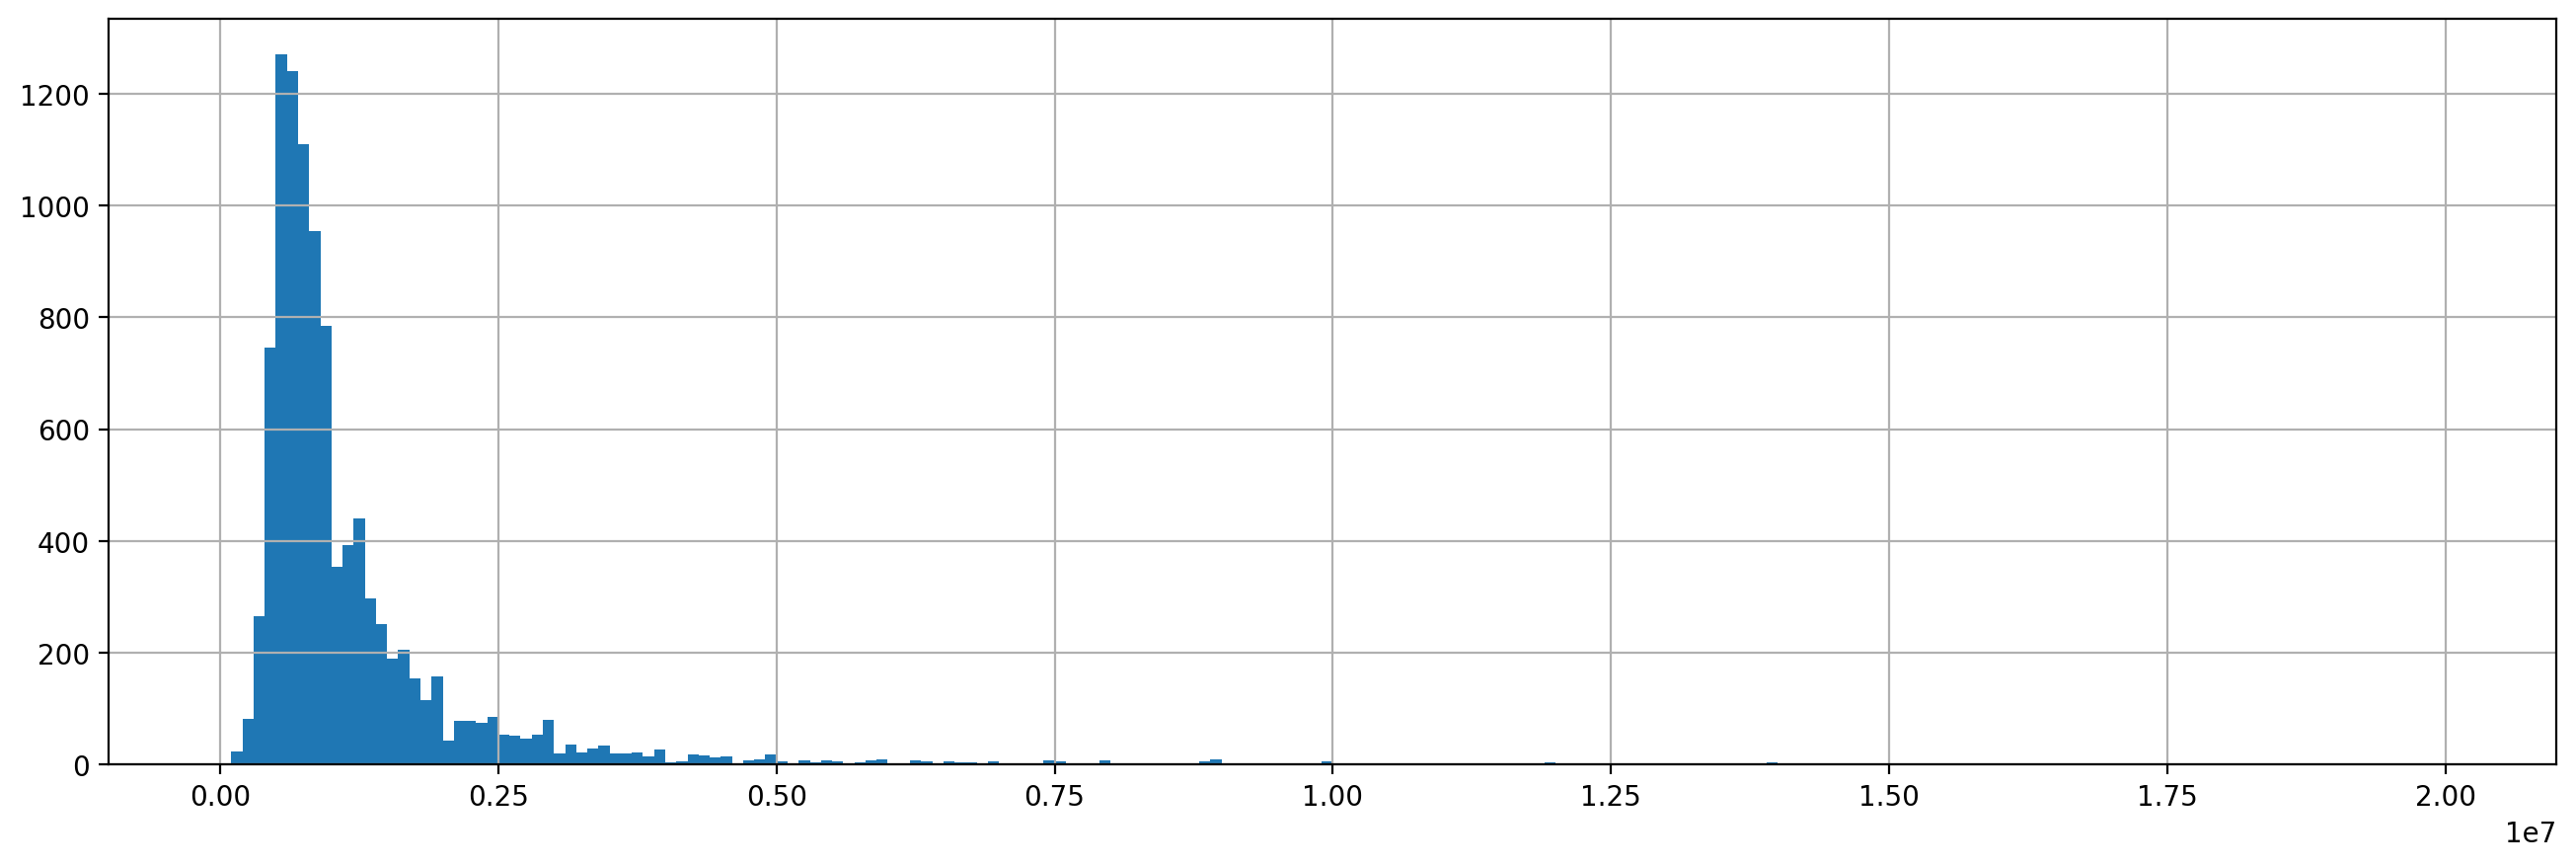

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5), dpi=200)
plt.hist(numerical_data['price'], bins = 200, range = [0, 2e7])
plt.grid()
plt.show()

In [5]:
numerical_data = numerical_data[numerical_data['price'] < 2.5e6]

In [6]:
len(numerical_data)

9392

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
def Data_preprocessing(df):
    scaler = MinMaxScaler()
    
    # Numerical Feature
    numerical_features = ["bedroom","bedroomAboveGrade","bedroomBelowGrade","bathroom", "bathroomTotal","bathroomPartial", 
                        "totalParkingSpaces", "storeys", "maintenanceFees",  'landSize']
    
    X_num = df[numerical_features]
    X_num = scaler.fit_transform(X_num)
    X_num = pd.DataFrame(X_num)
    df["longitude"] = df["longitude"] *0.01
    df["latitude"] = df["latitude"] *0.01
    df[numerical_features] = X_num
          
    # Boolean Feature
    boolean_features=['parkingAttachedGarage',
       'parkingUnderground', 'parkingInsideEntry', 'parkingSurfaced',
       'parkingOversize', 'parkingGravel', 'parkingGarage', 'parkingShared',
       'parkingDetachedGarage', 'parkingCarport', 'parkingInterlocked',
       'parkingVisitorParking','amenityClubhouse', 'amenityCarWash', 'amenityMusicRoom',
       'amenityStorageLocker', 'amenitySauna', 'amenityPartyRoom',
       'amenityRecreationCentre', 'amenityGuestSuite', 'amenityFurnished',
       'amenityLaundryFacility', 'amenityExerciseCentre',
       'amenityLaundryInSuite', 'amenitySecurity', 'amenityWhirlpool',
       'efinishWood', 'efinishBrick', 'efinishHardboard', 'efinishWoodsiding',
       'efinishLog', 'efinishMetal', 'efinishSteel', 'efinishStone',
       'efinishWoodshingles', 'efinishStucco', 'efinishSiding',
       'efinishConcrete', 'efinishShingles', 'efinishAluminumsiding',
       'efinishCedarshingles', 'efinishVinyl', 'efinishVinylsiding',
       'featurePetNotAllowed', 'AirportNearby',
       'GolfNearby', 'MarinaNearby', 'ShoppingNearby', 'WaterNearby',
       'WorshipPlaceNearby', 'RecreationNearby', 'PlaygroundNearby',
       'PublicTransitNearby', 'ParkNearby', 'SchoolsNearby', 'HospitalNearby',
       'HighwayNearby', 'SkiAreaNearby']
    
    # Category Feature
    cate_features = ['city', 'typeBuilding', 'title', 'styleAttach', 
                   'cooling',  'basementType', 'basementFinish',
                   'heatingType1', 'heatingType2', 'heatingEnergy1', 'heatingEnergy2', 
                   'featureLotSlope', 'featureDriveway', 'featureLotPositionType',
       'featureOutdoorAreaType', 'featureOutdoorLandscape',
       'featureAdditionalFacility']
    
    X_category=df[cate_features]
    for col in cate_features:
        X_category[col] = X_category[col].astype('category')
        X_category[col] = X_category[col].cat.codes
    df[cate_features] = X_category
    
    # Label Price
    labels_price = np.array(scaler.fit_transform(pd.DataFrame(df["price"]))).reshape(-1)
    df["price"] = labels_price
    df = df.dropna()
    return df, boolean_features, cate_features, numerical_features

In [8]:
from sklearn.model_selection import train_test_split
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
preprocessed_data, boolean_features, cate_features, numerical_features = Data_preprocessing(numerical_data)

C:\Users\yli62\AppData\Local\Temp/ipykernel_19188/2283544229.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].astype('category')
C:\Users\yli62\AppData\Local\Temp/ipykernel_19188/2283544229.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].cat.codes


In [14]:


class Generate_dataset(Dataset):
    def __init__(self, data_df, tokenizer, boolean_features,cate_features, numerical_features):
        self.MAX_SEQ_LEN = 128
        self.data = data_df
        self.tokenizer = tokenizer
        self.boolean = boolean_features
        self.cate = cate_features
        self.numerical = numerical_features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()

        boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
        cate_feature = torch.tensor(list(self.data.iloc[idx][self.cate]))
        numerical_feature = torch.tensor(list(self.data.iloc[idx][self.numerical]))
        description = self.data.iloc[idx]['description']
        print(description)
        word_encode = torch.tensor(self.tokenizer.encode(text= description,max_length=self.MAX_SEQ_LEN,padding='max_length', truncation=True))
        label = torch.tensor(float(self.data.iloc[idx]['price']))
        return {'description': word_encode, 'numerical_feature':numerical_feature, 'cate_feature':cate_feature, 'boolean_feature':boolean_feature, 'label':label}

In [15]:
X_train, X_test = train_test_split(preprocessed_data, test_size=0.1, random_state=13) 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [16]:
Train_dataset = Generate_dataset(X_train, tokenizer, boolean_features,cate_features, numerical_features)
Test_dataset = Generate_dataset(X_test, tokenizer, boolean_features,cate_features, numerical_features)

In [10]:
Train_dataloader = DataLoader(Train_dataset, batch_size = 16)
Test_dataloader = DataLoader(Test_dataset, batch_size = 16)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')
BERT_org = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
class BERT_Predictor(torch.nn.Module):
    def __init__(self, pretrained_model, tokenizer, predictor_size = 2):
        super(BERT_Predictor, self).__init__()
        self.bert = pretrained_model
        
#         for parameters in self.bert.parameters():
#             parameters.requires_grad=False
            
        self.PAD_INDEX = tokenizer.pad_token_id
        self.predictor = torch.nn.ModuleList()
        for _ in range(predictor_size):
            self.predictor.append(torch.nn.Linear(768,768))
            self.predictor.append(torch.nn.ReLU())
            self.predictor.append(torch.nn.Dropout(0.2))
        self.prediction = torch.nn.Linear(768, 1)
        
    def forward(self,input_ids):
        attention_mask = (input_ids != self.PAD_INDEX).type(torch.uint8)  
        outputs = self.bert(input_ids,attention_mask=attention_mask)
        pooled_output = outputs[1]
        
        for layer in self.predictor:
            pooled_output = layer(pooled_output)

        prediction = self.prediction(pooled_output)
        return prediction

In [13]:
Bert_regressor = BERT_Predictor(BERT_org, tokenizer).to(device)

In [14]:
from tqdm import tqdm

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def train(model,optimizer, train_iter,device,num_epochs):
    model.train()
    R2_final = []
    MSE = []
    R2_val = 0
    MSE_val = 0
    step = 0
    for _ in range(num_epochs):
        for data in tqdm(train_iter):
            optimizer.zero_grad()
            source = data['description'].to(device)
            target = data['label'].to(device).unsqueeze(-1)
            logits = model(input_ids=source)
            loss = torch.nn.MSELoss()(logits, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            MSE_val += float(loss)
            R2_val += float(r2_score(logits, target))
            if step%20 == 0:
                R2_final.append(R2_val/20)
                MSE.append(MSE_val/20)
                R2_val = 0
                MSE_val = 0               
            step += 1
        print('Loss is:', float(loss))
        print('R2 Score is:', float(r2_score(logits, target)))
    return MSE, R2_final

In [15]:
num_epochs = 5
lr_rate = 5e-5

In [16]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(Bert_regressor.named_parameters())
optimizer_grouped_parameters = [
        {
                'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                'weight_decay':0.01
        },
        {
                'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                'weight_decay':0.0
        }
]
total_steps = len(Train_dataloader) * num_epochs
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, optimizer_grouped_parameters[0]['params']), lr= lr_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*total_steps,num_training_steps=total_steps)

In [17]:
MSE, R2_final = train(Bert_regressor,optimizer, Train_dataloader,device,num_epochs)

  0%|                                                                                          | 0/480 [00:00<?, ?it/s]C:\Users\yli62\AppData\Local\Temp/ipykernel_3068/2889447223.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [02:55<00:00,  2.74it/s]


Loss is: 0.006203217897564173
R2 Score is: tensor(0.7108, device='cuda:0', grad_fn=<RsubBackward1>)


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [03:07<00:00,  2.57it/s]


Loss is: 0.006984645966440439
R2 Score is: tensor(0.6744, device='cuda:0', grad_fn=<RsubBackward1>)


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [03:08<00:00,  2.54it/s]


Loss is: 0.004566163290292025
R2 Score is: tensor(0.7872, device='cuda:0', grad_fn=<RsubBackward1>)


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [04:40<00:00,  1.71it/s]


Loss is: 0.0027895986568182707
R2 Score is: tensor(0.8700, device='cuda:0', grad_fn=<RsubBackward1>)


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [04:47<00:00,  1.67it/s]

Loss is: 0.0023804474622011185
R2 Score is: tensor(0.8890, device='cuda:0', grad_fn=<RsubBackward1>)


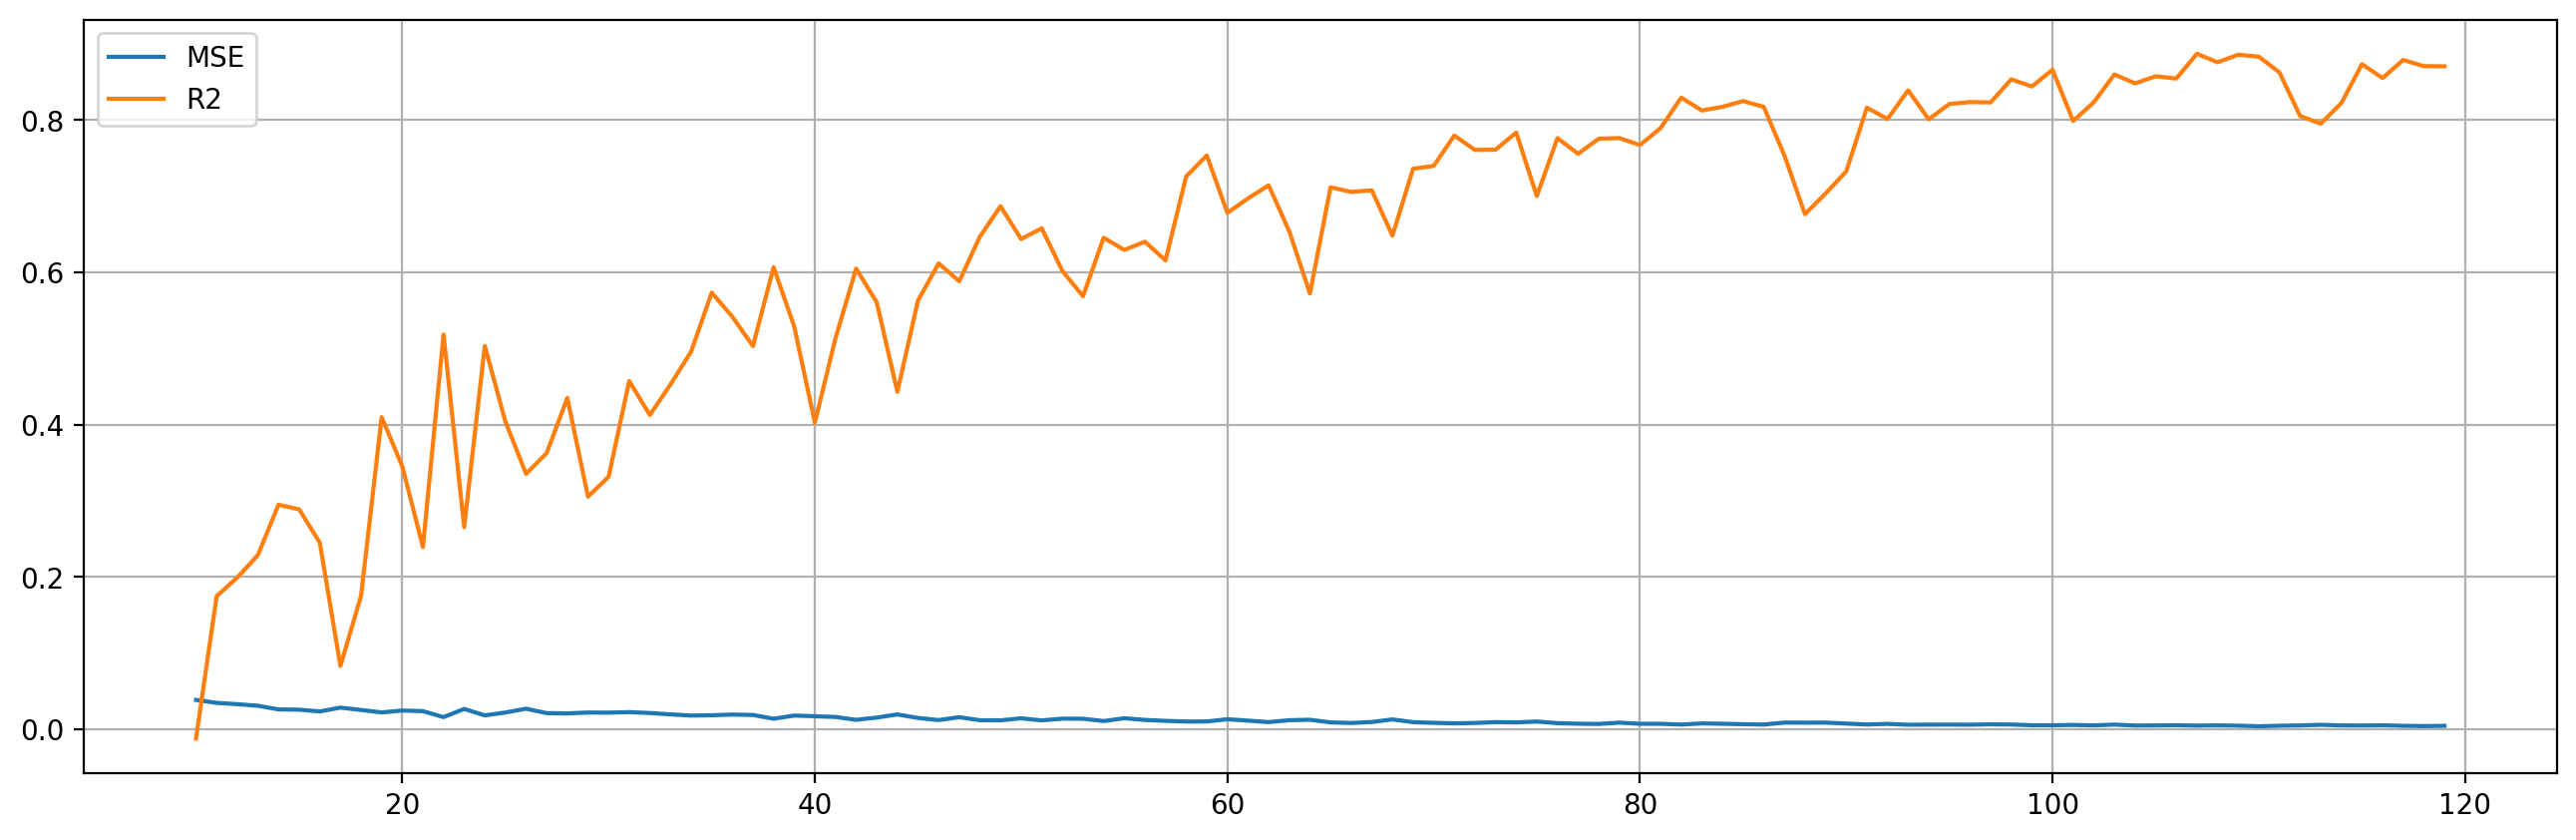

In [25]:

plt.figure(figsize=(16,5), dpi=200)
plt.plot(range(len(MSE))[10:], MSE[10:], label = 'MSE')
plt.plot(range(len(R2_final))[10:], R2_final[10:], label = 'R2')
plt.grid()
plt.legend()
plt.show()

In [18]:
def evaluate_attacker(model, test_iter):
    fin_targets = []
    fin_outputs = []
    model.eval()
    for data in tqdm(test_iter):
        source = data['description'].to(device)
        target= data['label'].to(device)
        logits = model(input_ids=source)
        fin_targets.extend(target.tolist())
        fin_outputs.extend(logits.tolist())
    return fin_targets,  fin_outputs

In [19]:
fin_targets,  fin_outputs = evaluate_attacker(Bert_regressor, Test_dataloader)

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]C:\Users\yli62\AppData\Local\Temp/ipykernel_3068/2889447223.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:21<00:00,  2.50it/s]


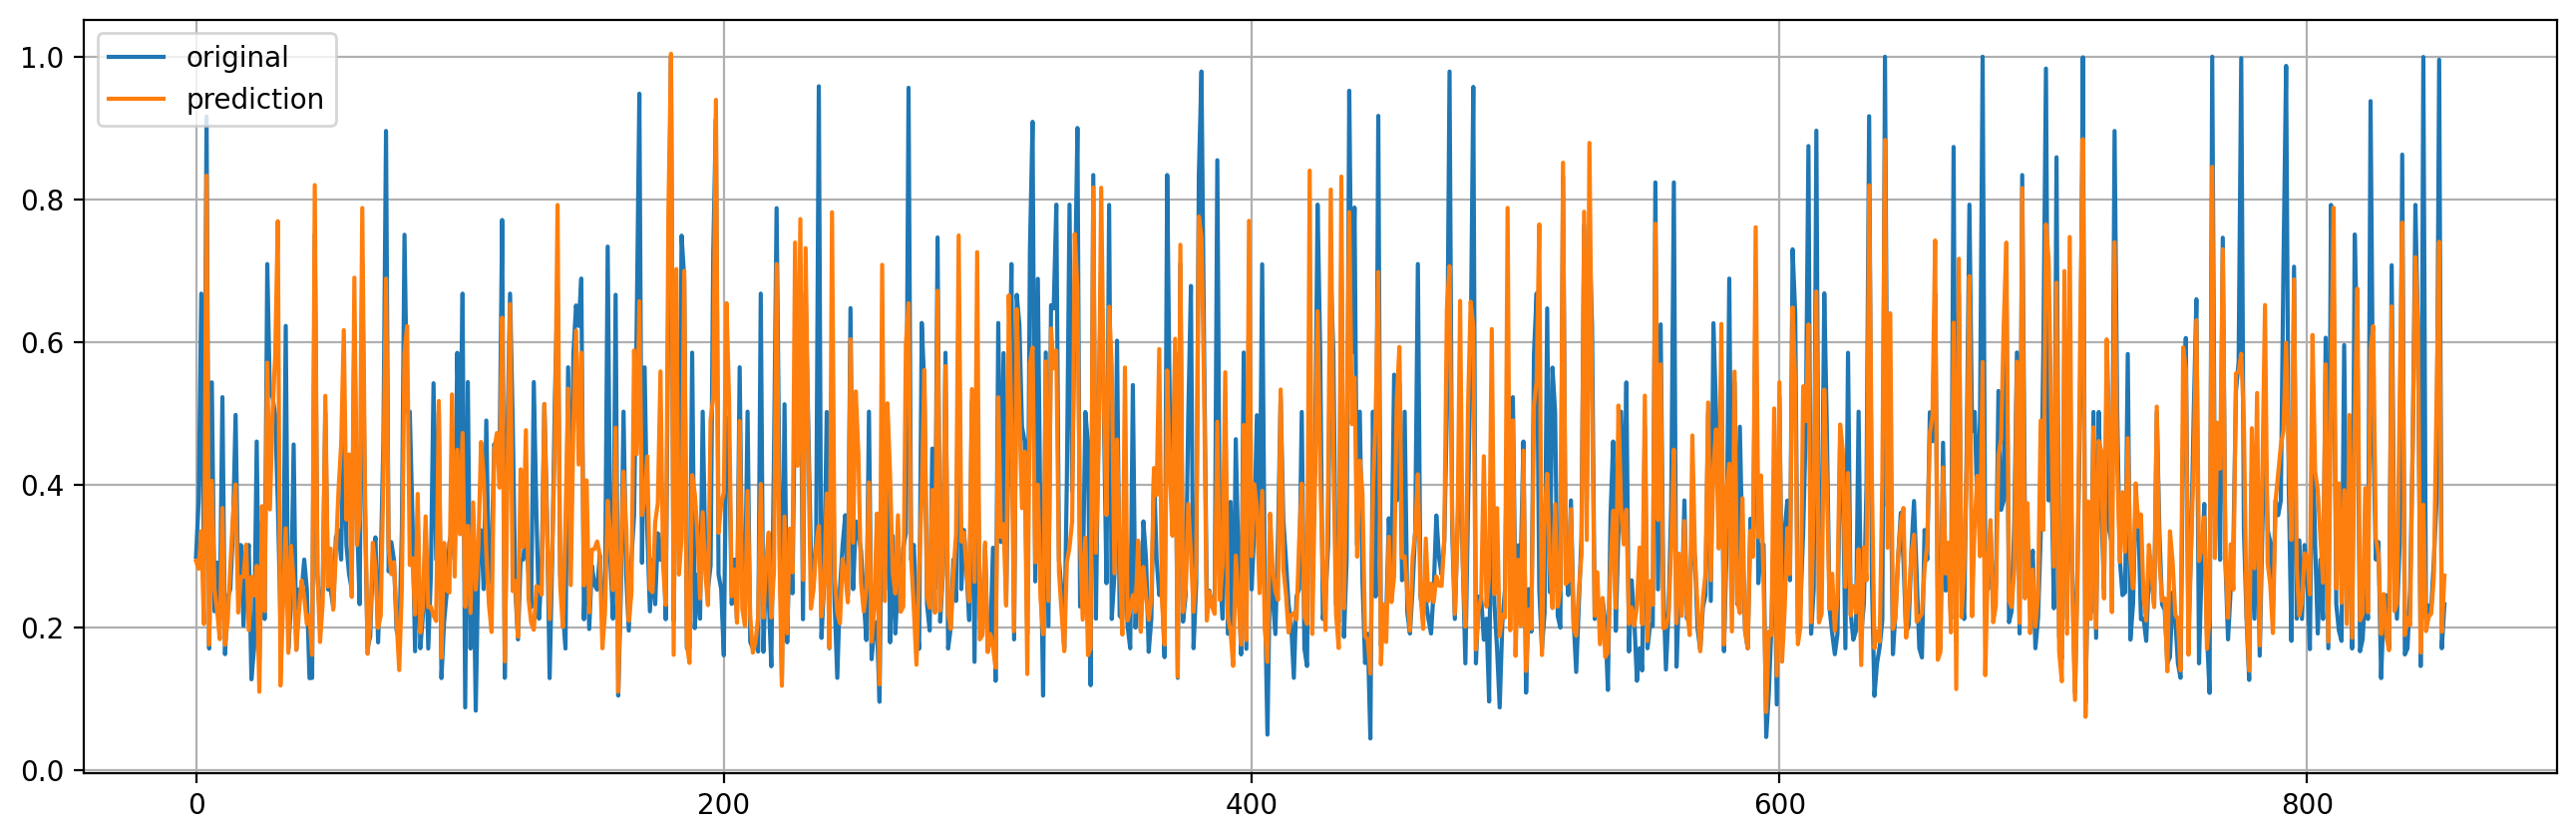

In [20]:

plt.figure(figsize=(16,5), dpi=200)
plt.plot(range(len(fin_targets)), fin_targets, label = 'original')
plt.plot(range(len(fin_targets)), fin_outputs, label = 'prediction')
plt.grid()
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score
r2_test = r2_score(fin_targets, fin_outputs)
print(r2_test)

0.6665465123101633


In [22]:
from sklearn.metrics import mean_squared_error
rmse_train=mean_squared_error(fin_targets, fin_outputs, squared=False)
print(rmse_train)

0.11819760162892935


In [ ]:
0.68983100 with encoder
0.69972150 without encoder
